In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv


In [20]:
input_path = "/kaggle/input/home-credit-default-risk/"
'''sample_submission = pd.read_csv(input_path + "sample_submission.csv")
bureau_balance = pd.read_csv(input_path + "bureau_balance.csv")
POS_CASH_balance = pd.read_csv(input_path + "POS_CASH_balance.csv")'''
application_train = pd.read_csv(input_path + "application_train.csv")
application_test = pd.read_csv(input_path + "application_test.csv")
'''with open(input_path + "HomeCredit_columns_description.csv",encoding = "utf-8", errors = "ignore") as f:
    HomeCredit_columns_description = f.read()
HomeCredit_columns_description = pd.read_csv(input_path + "HomeCredit_columns_description.csv", encoding = "ISO-8859-1")
application_test = pd.read_csv(input_path + "application_test.csv")
previous_application = pd.read_csv(input_path + "previous_application.csv")
credit_card_balance = pd.read_csv(input_path + "credit_card_balance.csv")
installments_payments = pd.read_csv(input_path + "installments_payments.csv")'''
bureau = pd.read_csv(input_path + "bureau.csv")

In [21]:
'''sample_submission.duplicated()
bureau_balance.duplicated()
POS_CASH_balance.duplicated()
application_train.duplicated()
HomeCredit_columns_description.duplicated()
application_test.duplicated()
previous_application.duplicated()
credit_card_balance.duplicated()
installments_payments.duplicated()
bureau.duplicated()'''

'sample_submission.duplicated()\nbureau_balance.duplicated()\nPOS_CASH_balance.duplicated()\napplication_train.duplicated()\nHomeCredit_columns_description.duplicated()\napplication_test.duplicated()\nprevious_application.duplicated()\ncredit_card_balance.duplicated()\ninstallments_payments.duplicated()\nbureau.duplicated()'

In [22]:
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

from sklearn.pipeline import make_pipeline
from sklearn.utils import resample

import gc

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [23]:
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [24]:
# Join to the training dataframe
train = application_train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

# Fill the missing values with 0 
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [25]:
def model(features, test_features, encoding = 'ohe', n_folds = 5, classifier = "lgd"):
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
      
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
     # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
    print("finished encoding")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    # Iterate through each fold
    print("start modelling")
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        if classifier == "lgd":
            # Create the model
            model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                       class_weight = 'balanced', learning_rate = 0.05, 
                                       reg_alpha = 0.1, reg_lambda = 0.1, 
                                       subsample = 0.8, n_jobs = -1, random_state = 50)

            # Train the model
            model.fit(train_features, train_labels, eval_metric = 'auc',
                      eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                      eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                      early_stopping_rounds = 100, verbose = 200)
            # Record the best iteration
            best_iteration = model.best_iteration_

            # Record the feature importances
            feature_importance_values += model.feature_importances_ / k_fold.n_splits
        elif classifier == "sgd":
            # Create the model
            model = make_pipeline(StandardScaler(),SGDClassifier(loss = "log", penalty = "elasticnet",
                                 early_stopping = True,validation_fraction = 0.2,class_weight = "balanced"))
            # Train the model
            #train_features = np.append(train_features,test_features)
            #train_labels = np.append(train_labels,valid_labels)
            model.fit(train_features, train_labels)
        elif classifier =="ada":
            #train_features = np.append(train_features,test_features)
            #train_labels = np.append(train_labels,valid_labels)
            model = AdaBoostClassifier(n_estimators=100, random_state=4995)
            model.fit(train_features,train_labels)
            
        elif classifier == "bnb":
            model = BernoulliNB()
            model.fit(train_features,train_labels)
            
        elif classifier == "gnb":
            model = GaussianNB()
            model.fit(train_features,train_labels)
        
        # Make predictions
        test_predictions += model.predict_proba(test_features)[:, 1] / k_fold.n_splits
       # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features)[:, 1]     
        if classifier == "lgd":

            # Record the best score
            valid_score = model.best_score_['valid']['auc']
            train_score = model.best_score_['train']['auc']

            valid_scores.append(valid_score)
            train_scores.append(train_score)
        
            # Clean up memory
            gc.enable()
            del model, train_features, valid_features
            gc.collect()
        #elif classifier =="sgd" or classifier =="ada" or classifier :
        else:
            valid_score = model.score(valid_features,valid_labels)
            valid_scores.append(valid_score) 
            
        print("finish fold")
    print("start prediction")       
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    

    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    fold_names=[]
    if classifier == "lgd":
        train_scores.append(np.mean(train_scores))
        # Make the feature importance dataframe
        feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
        # Needed for creating dataframe of validation scores
        fold_names = list(range(n_folds))
        fold_names.append('overall')
    
        # Dataframe of validation scores
        metrics = pd.DataFrame({'fold': fold_names,
                                'train': train_scores,
                                'valid': valid_scores}) 
    #elif classifier =="sgd" or classifier =="ada":
    else:
        metrics = pd.DataFrame({
                        'valid': valid_scores})
        feature_importances = "not avaliable"
    
    return submission, feature_importances, metrics

In [26]:
def plot_feature_importances(df):

    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    ax.invert_xaxis() 
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'blue', color="green")
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title(f'Top {len(df)} Importance Features')
    plt.show()
    
    return df

In [27]:
#originalData_ohe_lgd model
submission, fi, metrics = model(application_train, application_test)
submission.to_csv('base_ohe_lgd.csv', index = False)

finished encoding
Training Data Shape:  (307511, 241)
Testing Data Shape:  (48744, 241)


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


start modelling
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798402	train's binary_logloss: 0.548246	valid's auc: 0.760094	valid's binary_logloss: 0.561937
Early stopping, best iteration is:
[270]	train's auc: 0.809955	train's binary_logloss: 0.536899	valid's auc: 0.760435	valid's binary_logloss: 0.55484
finish fold
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798514	train's binary_logloss: 0.548241	valid's auc: 0.761102	valid's binary_logloss: 0.566424
Early stopping, best iteration is:
[223]	train's auc: 0.802473	train's binary_logloss: 0.544332	valid's auc: 0.761328	valid's binary_logloss: 0.564145
finish fold
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.799641	train's binary_logloss: 0.546889	valid's auc: 0.750166	valid's binary_logloss: 0.564526
Early stopping, best iteration is:
[224]	train's auc: 0.803744	train's binary_logloss: 0.542767	valid's auc: 0.750327	valid's

In [28]:
#originalData_le_lgd model
submission_le, fi_le, metrics_le = model(application_train, application_test,encoding = "le")
submission.to_csv('base_le_lgd.csv', index = False)

finished encoding
Training Data Shape:  (307511, 120)
Testing Data Shape:  (48744, 120)


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


start modelling


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1706: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 9, 10, 11, 12, 13, 26, 30, 38, 84, 85, 87, 88]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.807347	train's binary_logloss: 0.540021	valid's auc: 0.758436	valid's binary_logloss: 0.557524
Early stopping, best iteration is:
[225]	train's auc: 0.812018	train's binary_logloss: 0.535411	valid's auc: 0.758591	valid's binary_logloss: 0.554653
finish fold


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1706: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 9, 10, 11, 12, 13, 26, 30, 38, 84, 85, 87, 88]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.807294	train's binary_logloss: 0.54039	valid's auc: 0.758585	valid's binary_logloss: 0.561813
Early stopping, best iteration is:
[258]	train's auc: 0.81794	train's binary_logloss: 0.529628	valid's auc: 0.758883	valid's binary_logloss: 0.555314
finish fold


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1706: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 9, 10, 11, 12, 13, 26, 30, 38, 84, 85, 87, 88]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.809185	train's binary_logloss: 0.538262	valid's auc: 0.749823	valid's binary_logloss: 0.558875
Early stopping, best iteration is:
[244]	train's auc: 0.8174	train's binary_logloss: 0.529937	valid's auc: 0.749996	valid's binary_logloss: 0.553627
finish fold


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1706: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 9, 10, 11, 12, 13, 26, 30, 38, 84, 85, 87, 88]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.806824	train's binary_logloss: 0.540941	valid's auc: 0.758217	valid's binary_logloss: 0.557292
Early stopping, best iteration is:
[171]	train's auc: 0.801047	train's binary_logloss: 0.546705	valid's auc: 0.758741	valid's binary_logloss: 0.560803
finish fold


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1706: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 9, 10, 11, 12, 13, 26, 30, 38, 84, 85, 87, 88]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.807167	train's binary_logloss: 0.540867	valid's auc: 0.760093	valid's binary_logloss: 0.557786
Early stopping, best iteration is:
[271]	train's auc: 0.819621	train's binary_logloss: 0.528354	valid's auc: 0.760518	valid's binary_logloss: 0.550222
finish fold
start prediction


In [29]:
#Filling NaNs
_train = train.fillna(0)
_test = application_test.fillna(0)

In [30]:
#DataWithPreviousLoan_ohe_sgd model
submission_sgd, fi_sgd, metrics_sgd = model(_train, _test,encoding = "ohe",classifier = "sgd")
submission_sgd.to_csv('base_ohe_sgd.csv', index = False)

finished encoding
Training Data Shape:  (307511, 247)
Testing Data Shape:  (48744, 247)


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


start modelling
finish fold
finish fold
finish fold
finish fold
finish fold
start prediction


In [31]:
#DataWithPreviousLoan_ohe_ada model
submission_ada, fi_ada, metrics_ada = model(_train, _test,encoding = "ohe",classifier = "ada")
submission_ada.to_csv('base_ohe_ada.csv', index = False)

finished encoding
Training Data Shape:  (307511, 247)
Testing Data Shape:  (48744, 247)


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


start modelling
finish fold
finish fold
finish fold
finish fold
finish fold
start prediction


In [32]:
#Bernoulli Naive Bayes
submission_bnb, fi_bnb, metrics_bnb = model(_train, _test,encoding = "ohe",classifier = "bnb")
submission_bnb.to_csv('base_ohe_bnb.csv', index = False)

finished encoding
Training Data Shape:  (307511, 247)
Testing Data Shape:  (48744, 247)


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


start modelling
finish fold
finish fold
finish fold
finish fold
finish fold
start prediction


In [33]:
#Gaussian Naive Bayes
submission_gnb, fi_gnb, metrics_gnb = model(_train, _test,encoding = "ohe",classifier = "gnb")
submission_gnb.to_csv('base_ohe_gnb.csv', index = False)

finished encoding
Training Data Shape:  (307511, 247)
Testing Data Shape:  (48744, 247)


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


start modelling
finish fold
finish fold
finish fold
finish fold
finish fold
start prediction


In [34]:
#save result
result = pd.DataFrame([submission, fi, metrics])
result_le = pd.DataFrame([submission_le, fi_le, metrics_le])
result_sgd = pd.DataFrame([submission_sgd, fi_sgd, metrics_sgd])
result_ada = pd.DataFrame([submission_ada, fi_ada, metrics_ada])
result_bnb = pd.DataFrame([submission_bnb, fi_bnb, metrics_bnb])
result_gnb = pd.DataFrame([submission_gnb, fi_gnb, metrics_gnb])
result = pd.concat([result,result_le,result_sgd,result_ada,result_bnb,result_gnb],axis=1,keys=['ohe','le','sgd','bnb','gnb'])
result.to_csv("result.csv",index=False)

/opt/conda/lib/python3.7/site-packages/pandas/core/internals/construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])


In [35]:
#start feature selection
corr = train.corr()
corr = corr.sort_values('TARGET', ascending = False)

# Ten most positive correlations
pd.DataFrame(corr['TARGET'].head(10))

,TARGET
TARGET,1.000000
DAYS_BIRTH,0.078239
REGION_RATING_CLIENT_W_CITY,0.060893
REGION_RATING_CLIENT,0.058899
DAYS_LAST_PHONE_CHANGE,0.055218
DAYS_ID_PUBLISH,0.051457
REG_CITY_NOT_WORK_CITY,0.050994
FLAG_EMP_PHONE,0.045982
REG_CITY_NOT_LIVE_CITY,0.044395
FLAG_DOCUMENT_3,0.044346


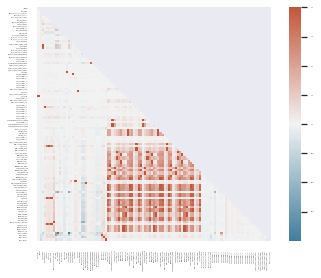

In [36]:
#plotting heatmap for correlation
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.set(font_scale=0.1)
sns.heatmap(corr, mask=mask, cmap=cmap, square=True)
plt.show()

In [37]:
# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corr:
    above_threshold_vars[col] = list(corr.index[corr[col] > threshold])

In [38]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  39


In [39]:
#dataset after remove high corr var
train_corr_removed = train.drop(columns = cols_to_remove)
test_corr_removed = application_test.drop(columns = cols_to_remove)

In [40]:
#remove_cor_ohe_lgd model  #score = 0.74232
submission_cor, fi_cor, metrics_cor = model(train_corr_removed, test_corr_removed)
submission_cor.to_csv('corr_ohe_lgd.csv', index = False)

finished encoding
Training Data Shape:  (307511, 202)
Testing Data Shape:  (48744, 202)


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


start modelling
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.794189	train's binary_logloss: 0.552165	valid's auc: 0.75706	valid's binary_logloss: 0.565158
[400]	train's auc: 0.823256	train's binary_logloss: 0.523883	valid's auc: 0.757152	valid's binary_logloss: 0.547397
Early stopping, best iteration is:
[307]	train's auc: 0.810724	train's binary_logloss: 0.536144	valid's auc: 0.757533	valid's binary_logloss: 0.555092
finish fold
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.794814	train's binary_logloss: 0.551788	valid's auc: 0.757196	valid's binary_logloss: 0.569725
Early stopping, best iteration is:
[273]	train's auc: 0.806473	train's binary_logloss: 0.540561	valid's auc: 0.757443	valid's binary_logloss: 0.563151
finish fold
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.795987	train's binary_logloss: 0.550226	valid's auc: 0.747509	valid's binary_logloss: 0.567672
Early sto

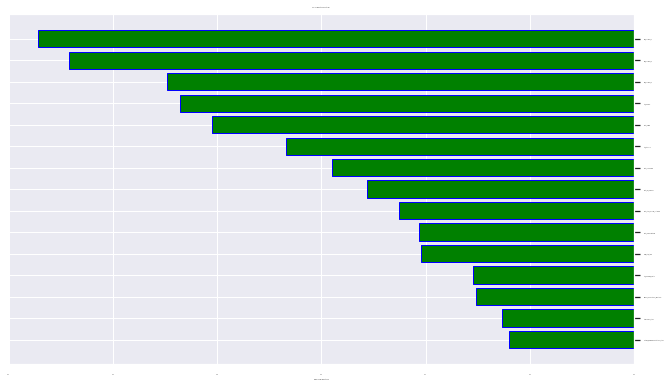

In [41]:
#The top 10 important feature 
fi_cor_sorted = plot_feature_importances(fi_cor.sort_values("importance",ascending=False).head(20))
top_10_features = fi_cor_sorted.head(10)["feature"]

#dataset after remove high corr var
top_10_features = np.append(top_10_features.values,"SK_ID_CURR")
test_10_features = test_corr_removed[top_10_features]
train_10_features = train_corr_removed[np.append(top_10_features,"TARGET")]

In [42]:
#10_features_ohe_lgd model #score = 0.73086
submission_10, fi_10, metrics_10 = model(train_10_features, test_10_features)
submission_10.to_csv('10_features_ohe_lgd.csv', index = False)

finished encoding
Training Data Shape:  (307511, 10)
Testing Data Shape:  (48744, 10)
start modelling


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.776096	train's binary_logloss: 0.568921	valid's auc: 0.742108	valid's binary_logloss: 0.579161
Early stopping, best iteration is:
[152]	train's auc: 0.769371	train's binary_logloss: 0.575202	valid's auc: 0.74251	valid's binary_logloss: 0.582759
finish fold
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.77617	train's binary_logloss: 0.569122	valid's auc: 0.744329	valid's binary_logloss: 0.584267
Early stopping, best iteration is:
[252]	train's auc: 0.783518	train's binary_logloss: 0.562239	valid's auc: 0.744611	valid's binary_logloss: 0.580414
finish fold
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.777243	train's binary_logloss: 0.567825	valid's auc: 0.736145	valid's binary_logloss: 0.581074
Early stopping, best iteration is:
[174]	train's auc: 0.773649	train's binary_logloss: 0.571245	valid's auc: 0.736195	valid's binary_logloss: 

In [43]:
#The top 20 important feature  
top_20_features = fi_cor_sorted["feature"]

#dataset after remove high corr var
top_20_features = np.append(top_20_features.values,"SK_ID_CURR")
test_20_features = test_corr_removed[top_20_features]
train_20_features = train_corr_removed[np.append(top_20_features,"TARGET")]

In [44]:
#20_features_ohe_lgd model #score = 0.73327
submission_20, fi_20, metrics_20 = model(train_20_features, test_20_features)
submission_20.to_csv('20_features_ohe_lgd.csv', index = False)

finished encoding
Training Data Shape:  (307511, 20)
Testing Data Shape:  (48744, 20)
start modelling


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.784322	train's binary_logloss: 0.561589	valid's auc: 0.74645	valid's binary_logloss: 0.574037
Early stopping, best iteration is:
[166]	train's auc: 0.778768	train's binary_logloss: 0.566852	valid's auc: 0.74677	valid's binary_logloss: 0.576912
finish fold
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.784243	train's binary_logloss: 0.561825	valid's auc: 0.748851	valid's binary_logloss: 0.578902
[400]	train's auc: 0.812816	train's binary_logloss: 0.534828	valid's auc: 0.74864	valid's binary_logloss: 0.563288
Early stopping, best iteration is:
[318]	train's auc: 0.802122	train's binary_logloss: 0.54504	valid's auc: 0.749004	valid's binary_logloss: 0.569353
finish fold
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.785701	train's binary_logloss: 0.560257	valid's auc: 0.738043	valid's binary_logloss: 0.575902
Early stopping, best iterati

In [45]:
#The top 10 important feature in application train
top_10_features = fi_cor_sorted.head(10)["feature"]

#dataset after remove high corr var
top_10_features = np.append(top_10_features.values,"SK_ID_CURR")
test_10_features = application_test[top_10_features]
train_10_features = application_train[np.append(top_10_features,"TARGET")]

#10_app_features_ohe_lgd model #score = 
submission_10, fi_10, metrics_10 = model(train_10_features, test_10_features)
submission_10.to_csv('10_app_features_ohe_lgd.csv', index = False)

finished encoding
Training Data Shape:  (307511, 10)
Testing Data Shape:  (48744, 10)
start modelling


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.776096	train's binary_logloss: 0.568921	valid's auc: 0.742108	valid's binary_logloss: 0.579161
Early stopping, best iteration is:
[152]	train's auc: 0.769371	train's binary_logloss: 0.575202	valid's auc: 0.74251	valid's binary_logloss: 0.582759
finish fold
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.77617	train's binary_logloss: 0.569122	valid's auc: 0.744329	valid's binary_logloss: 0.584267
Early stopping, best iteration is:
[252]	train's auc: 0.783518	train's binary_logloss: 0.562239	valid's auc: 0.744611	valid's binary_logloss: 0.580414
finish fold
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.777243	train's binary_logloss: 0.567825	valid's auc: 0.736145	valid's binary_logloss: 0.581074
Early stopping, best iteration is:
[174]	train's auc: 0.773649	train's binary_logloss: 0.571245	valid's auc: 0.736195	valid's binary_logloss: 

In [46]:
#The top 20 important feature 
top_20_features = fi_cor_sorted["feature"]

#dataset after remove high corr var
top_20_features = np.append(top_20_features.values,"SK_ID_CURR")
test_20_features = application_test[top_20_features]
train_20_features = application_train[np.append(top_20_features,"TARGET")]

#20_features_ohe_lgd model in application train #score = 
submission_20, fi_20, metrics_20 = model(train_20_features, test_20_features)
submission_20.to_csv('20_app_features_ohe_lgd.csv', index = False)

finished encoding
Training Data Shape:  (307511, 20)
Testing Data Shape:  (48744, 20)
start modelling


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.784322	train's binary_logloss: 0.561589	valid's auc: 0.74645	valid's binary_logloss: 0.574037
Early stopping, best iteration is:
[166]	train's auc: 0.778768	train's binary_logloss: 0.566852	valid's auc: 0.74677	valid's binary_logloss: 0.576912
finish fold
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.784243	train's binary_logloss: 0.561825	valid's auc: 0.748851	valid's binary_logloss: 0.578902
[400]	train's auc: 0.812816	train's binary_logloss: 0.534828	valid's auc: 0.74864	valid's binary_logloss: 0.563288
Early stopping, best iteration is:
[318]	train's auc: 0.802122	train's binary_logloss: 0.54504	valid's auc: 0.749004	valid's binary_logloss: 0.569353
finish fold
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.785701	train's binary_logloss: 0.560257	valid's auc: 0.738043	valid's binary_logloss: 0.575902
Early stopping, best iterati